<a href="https://colab.research.google.com/github/yuhec/Kickstarter_moovai/blob/main/KS_moovai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import des données

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin

path = 'drive/My Drive/Colab Notebooks/ks_dataset.csv'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pwd

/content


In [4]:
def load_csv(path):
  rows = []
  # Lecture du fichier CSV ligne par ligne
  with open(path, 'r', encoding='latin-1') as file:
    for line in file:
        # Suppression des espaces en début et fin de ligne
        line = line.strip()

        columns = []
        start_index = 0
        current_value = ""
        in_quotes = False
        for i in range(len(line)):
          # Séparation de la ligne par les virgules, tout en préservant les virgules dans la colonne "name"
          if line[i] == ',' and i+1 < len(line) and line[i+1] != ' ' and not in_quotes:
            columns.append(current_value)
            current_value = ""
            start_index += 1
          elif line[i] == ',' and i+1 == len(line) and not in_quotes:
            columns.append(current_value)
            current_value = ""
            start_index += 1
          else:
            current_value += line[i]

          if line[i] == '"':
            in_quotes = not in_quotes

        # Ajout de la ligne traitée à la liste des lignes
        rows.append(columns)

  df = pd.DataFrame(rows[1:], columns=rows[0])

  return df

In [5]:
df = load_csv(path)
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,,,
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0,,,
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220,,,
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1,,,
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283,,,
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375,,,


In [6]:
# Pour obtenir le nombre de lignes et de colonnes du dataframe
nombre_lignes, nombre_colonnes = df.shape

print("Nombre de lignes :", nombre_lignes)
print("Nombre de colonnes :", nombre_colonnes)
print("Nom des colonnes :", df.columns)

Nombre de lignes : 323750
Nombre de colonnes : 16
Nom des colonnes : Index(['ID ', 'name ', 'category ', 'main_category ', 'currency ', 'deadline ',
       'goal ', 'launched ', 'pledged ', 'state ', 'backers ', 'country ',
       'usd pledged ', '', '', ''],
      dtype='object')


In [7]:
# Les colonnes ont un espace en trop dans leur nom...
df = df.rename(columns=lambda x: x.replace(' ', ''))

# Supprimer les 4 dernières colonnes qui ne sont pas définis
df = df.iloc[:, :-3] # Sélectionne toutes les lignes et les colonnes jusqu'`a x

df.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usdpledged'],
      dtype='object')

# Exploration des données

### Définition des colonnes et pistes d'exploration
Colonnes :
- ID : identifiant unique
- Name : il pourrait être intéressant d'étudier son impact dans la compagne.
  - Plus le titre est long, moins il a d'impact ?
  - Si le titre est trop court, il n'y a pas assez de détails, les gens seraient moins intéressés ?
  - Un nombre adéquat de caratères pour qu'il ait un impact ?
  - NLP : étudier sa sémantique (titre positif/ négatif - sentiment analysis) -- Pour des raisons de temps, on écarte cette hypothèse, pour commencer
- Category & Main Category : Combien il a de catégories ? .
  - Certaines catégories ont plus d'impact que d'autres ?
  - Est ce qu'il vaut mieux prendre main_category pour être plus général ou est-ce que le moment ne serait pas assez précis ?
- Deadline & Launched : date de lancement et de fin de la campagne.
  - Est-ce qu'il y a des périodes où il y a le plus de campagnes réussites ? Le moins ? (année/ mois)
  - Est-ce que la durée d'une campagne a un impact sur sa réussite (ajouter nouvelle colonne qui va calculer la durée)
- Goal : le montant à atteindre.
  - Est-ce qu'un goal élevé impacte la réussite de la campagne ?
  - Quelle est la répartition des Goals, par catégorie ? Peut-être que certaines catégories nécéssitent plus de moyen que d'autres ?
  - Quelle est la moyenne des Goals par catégorie ? Est-ce que d'être au dessus ou en dessus de cette moyenne impacte la réussite de la campagne ?
- Pledged & Usd pledged : promesses de dons.
- Backers : contributeurs, nombre de personnes différentes qui ont fait une promesse de dons.
  - Plus il y a un goal haut, plus il y a de contributeurs ?
  - Y a t il un minimum de contributeurs moyen à avoir pour réussir une campagne ?
- Country : pays dans lequel a lieu la campagne.
  - Quelle est la répartition des pays ?
  - Le taux de réussite ?
- Currency : monnaie.
  - En lien direct avec les pays ? Est-ce qu'un pays n'a pas sa monnaie ?
  - Il y a plus de dons en USD ?
- State : l'état de la compagne, sera notre **Target** pour le modèle.
  - Regarder la répartition des résultats. Jeu équilibré ?
  - Combien il y a de canceled ?
  - Est-ce qu'on les retire du jeu pour le modèle ? Quelle est leur pertinence ?

NB : c'est dommage que l'on n'est pas la date du state. Ca pourrait nous indiquer pourquoi une campagne a été cancelled par exemple.

In [8]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usdpledged
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09 11:36:00,1000,2015-08-11 12:12:28,0,failed,0,GB,0
1,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26 00:20:50,45000,2013-01-12 00:20:50,220,failed,3,US,220
2,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16 04:24:11,5000,2012-03-17 03:24:11,1,failed,1,US,1
3,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29 01:00:00,19500,2015-07-04 08:35:03,1283,canceled,14,US,1283
4,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01 13:38:27,50000,2016-02-26 13:38:27,52375,successful,224,US,52375


In [9]:
# Pour afficher les types des colonnes
print(df.dtypes)

print('--------------------------------')

# Pour afficher le nombre de valeurs nulles ou NaN par colonne
print(df.isnull().sum())

ID               object
name             object
category         object
main_category    object
currency         object
deadline         object
goal             object
launched         object
pledged          object
state            object
backers          object
country          object
usdpledged       object
dtype: object
--------------------------------
ID               0
name             0
category         0
main_category    0
currency         0
deadline         0
goal             0
launched         0
pledged          0
state            0
backers          0
country          0
usdpledged       1
dtype: int64


In [10]:
# Convertir les colonnes avec des valeurs exclusivement numériques
# Toutes les lignes qui n'ont pas une valeur numérique sur la colonne goal, pledged et backers, on va les supprimer du jeu de données
rows = df.shape[0]

for column in ['goal', 'pledged', 'backers']:
  df[column] = pd.to_numeric(df[column], errors='coerce')
  df = df.dropna(subset=[column])
  df = df.reset_index(drop=True)

print(rows - df.shape[0]," lignes supprimées")

74  lignes supprimées


In [11]:
def create_pie(x, title):
  fig, ax = plt.subplots()

  ax.pie(x.values, labels=x.index, radius=3, center=(4, 4),
        wedgeprops={"linewidth": 1, "edgecolor": "white"}, frame=True, autopct='%1.1f%%')
  ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
        ylim=(0, 8), yticks=np.arange(1, 8))
  plt.title(title)
  plt.axis('off')
  plt.show()

## Étude du State (variable target) et de sa répartion

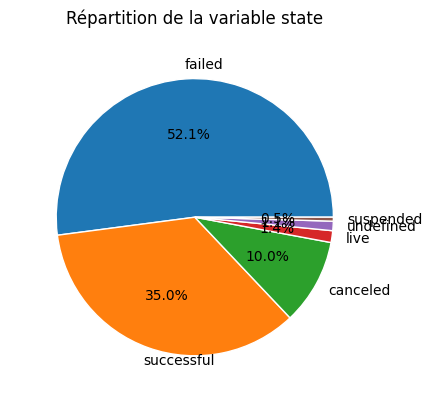

In [12]:
x = df["state"].value_counts()
create_pie(x, "Répartition de la variable state")

In [13]:
df['state'].unique()

array(['failed', 'canceled', 'successful', 'live', 'undefined',
       'suspended'], dtype=object)

In [14]:
# On va remplacer les states différent de failed et successful pour pouvoir résoudre un problème de classification binaire après
class FormatTarget(BaseEstimator, TransformerMixin):
    def __init__(self):
      pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
      condition = (X['state'].isin(['live', 'undefined'])) & (X['pledged'] >= X['goal'])
      X['state'] = np.where(condition, 'successful', np.where(X['state'].isin(['live', 'undefined']), 'failed', X['state']))
      X['state'] = X['state'].replace(['canceled', 'suspended'], 'failed')
      return X

In [15]:
format_target = FormatTarget()
df = format_target.transform(df)

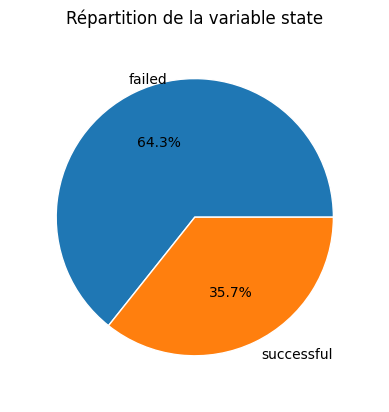

In [16]:
x = df["state"].value_counts()
create_pie(x, "Répartition de la variable state")
# On a donc une répartition non équitable entre failed et successful

# Exploration des catégories

 Est-ce que certaines catégories de projets ont tendance à être plus réussies que d'autres ?

In [17]:
print("Nombre de catégorie: ", len(df['category'].unique()))
print("Nombre de catégorie principale: ", len(df['main_category'].unique()))

Nombre de catégorie:  158
Nombre de catégorie principale:  15


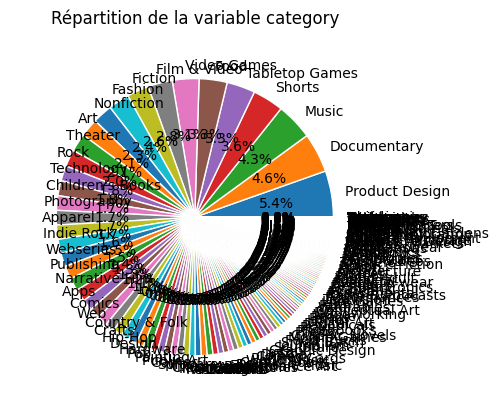

In [18]:
x = df["category"].value_counts()
create_pie(x, "Répartition de la variable category")

# Il y a beaucoup trop de catégories différentes pour pouvoir les exploiter et généraliser leur succès

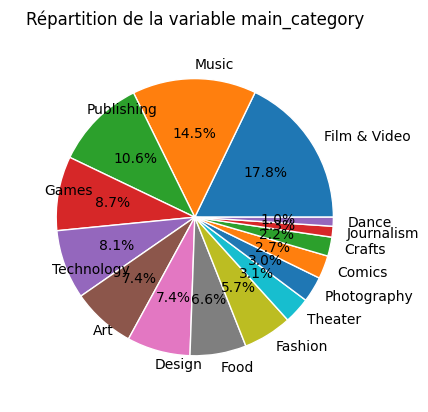

In [19]:
x = df["main_category"].value_counts()
create_pie(x, "Répartition de la variable main_category")

# La répartition des main_category n'est pas équitable... Néanmoins, 5 catégories princpales se démarquent : Technology, Games, Publishing, Music, Film & Video

In [20]:
grouped = df.groupby(['main_category', 'state']).size().reset_index(name='count')

# Pivotement des données pour obtenir une matrice de croisement
cross_matrix = pd.pivot_table(grouped, values='count', index='main_category', columns='state', fill_value=0)

# Calcul des taux de succès et d'échecs
cross_matrix['success rate'] = cross_matrix['successful'] / (cross_matrix['successful'] + cross_matrix['failed'])
cross_matrix['failure rate'] = cross_matrix['failed'] / (cross_matrix['successful'] + cross_matrix['failed'])

# Calcul du pourcentage de projets par catégorie
df_matrix = pd.DataFrame(cross_matrix, columns=['failed', 'successful', 'success rate', 'failure rate'])
total_success = df_matrix['successful'].sum()
total_failed = df_matrix['failed'].sum()

df_matrix['distribution rate'] = df_matrix.apply(lambda row: (row['failed'] + row['successful']) / (total_failed + total_success) * 100, axis=1)

# Affichage de la matrice de croisement avec les taux de succès et d'échecs
df_matrix['success rate'] = df_matrix['success rate'].round(2)
df_matrix['failure rate'] = df_matrix['failure rate'].round(2)
df_matrix['distribution rate'] = df_matrix['distribution rate'].round(2)

pd.set_option('display.width', 1000)
print(df_matrix)

# theater, dance et comics ont un taux de réussite > à 50%
# Music a un taux de réussite proche de 50 %
# Ce n'est pas parce qu'il y a beaucoup de campagnes sur une catégorie que cela signifie que la catégorie a un fort taux de réussite
# On peut dire que les catégories de musique, theatre, dance et comics sont plus susceptibles de réussir leur campagne comparé aux autres catégories

               failed  successful  success rate  failure rate  distribution rate
main_category                                                                   
Art             14305        9715          0.40          0.60               7.42
Comics           4213        4544          0.52          0.48               2.71
Crafts           5506        1685          0.23          0.77               2.22
Dance            1270        2106          0.62          0.38               1.04
Design          15792        8111          0.34          0.66               7.38
Fashion         14050        4362          0.24          0.76               5.69
Film & Video    35920       21813          0.38          0.62              17.84
Food            15952        5287          0.25          0.75               6.56
Games           18531        9506          0.34          0.66               8.66
Journalism       3209         873          0.21          0.79               1.26
Music           23642       

<Axes: xlabel='main_category', ylabel='count'>

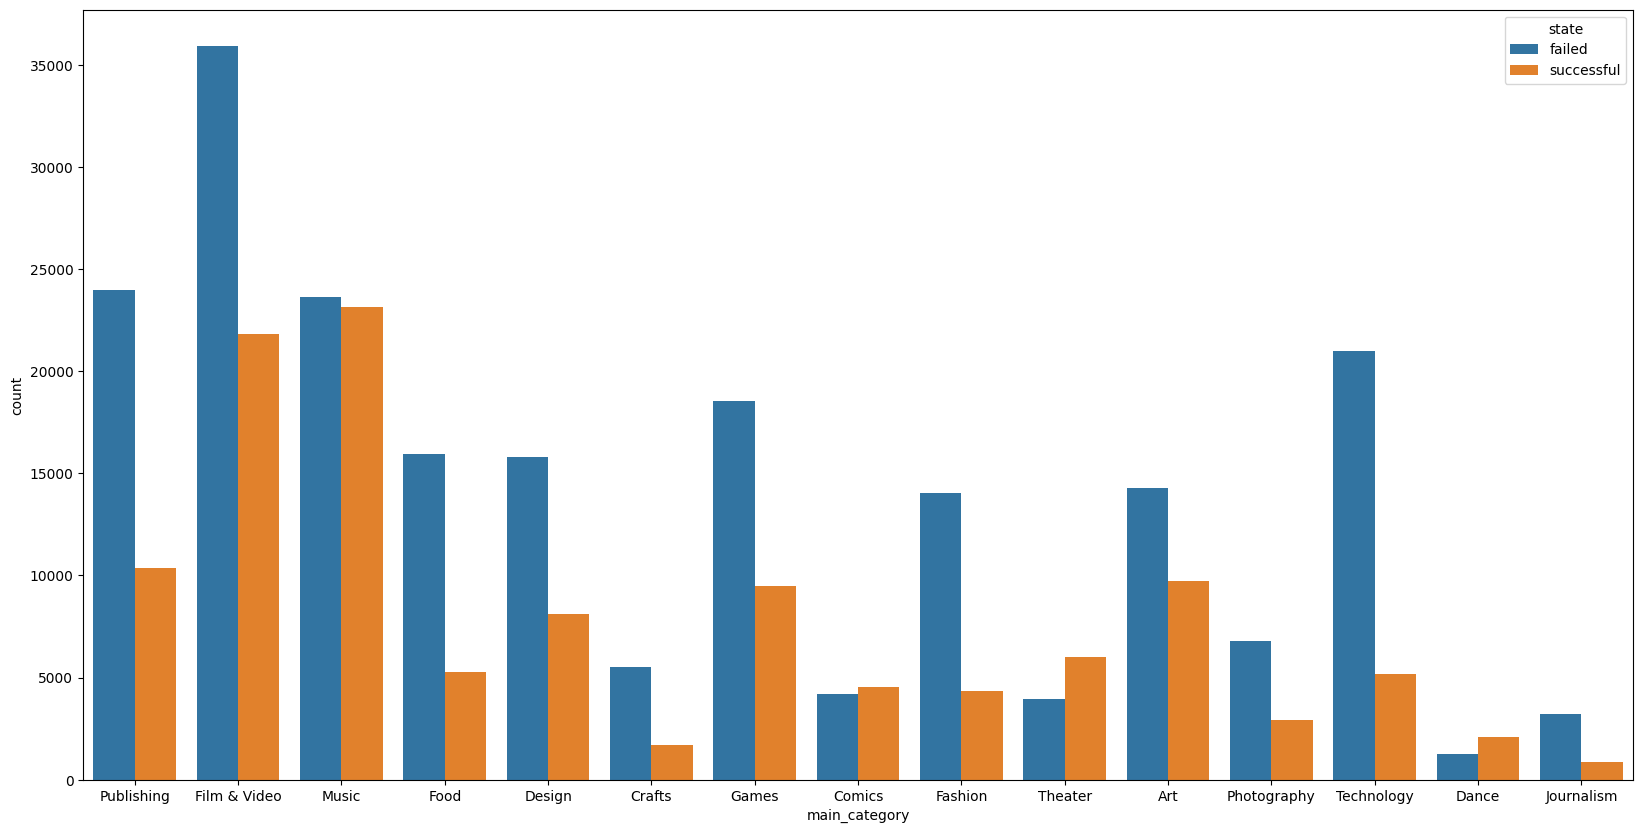

In [21]:
plt.figure(figsize=(20,10))
sns.countplot(x='main_category', hue='state', data=df)

# Exploration de la durée d'une campagne

Est-ce que la durée d'une campagne influence son succès ? Les campagnes plus courtes ou plus longues ont-elles des taux de réussite différents ?

In [22]:
class CalculateElapsedTime(BaseEstimator, TransformerMixin):
    def __init__(self):
      pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
      X['deadline'] = pd.to_datetime(X['deadline'])
      X['launched'] = pd.to_datetime(X['launched'])
      X['time_elapsed'] = X['deadline'] - X['launched']
      X['time_elapsed'] = X['time_elapsed'].dt.total_seconds()
      return X

In [23]:
calculate_elapsed_time = CalculateElapsedTime()
df = calculate_elapsed_time.transform(df)

In [24]:
df['time_elapsed'].describe()

# Beaucoup de valeurs eloigées...
# Puisque le min et le max sont très différents, on va utiliser une transformation logarithmique pour étaler les valeurs sur une plage plus étroite

count    3.236760e+05
mean     2.999903e+06
std      6.144961e+06
min      8.640000e+04
25%      2.592000e+06
50%      2.592000e+06
75%      3.279600e+06
max      1.446279e+09
Name: time_elapsed, dtype: float64

In [25]:
class NormalizedLogarithme(BaseEstimator, TransformerMixin):
  def __init__(self, col):
        self.col = col

  def fit(self, X, y=None):
      return self

  def transform(self, X):
    col_values = X[self.col].values
    log_transformed_values = np.log1p(col_values)
    X["%s%s" % (self.col, '_normalized')] = log_transformed_values
    return X

In [26]:
norm_log = NormalizedLogarithme(col='time_elapsed')
df = norm_log.transform(df)

In [27]:
df['time_elapsed_normalized'].describe()

count    323676.000000
mean         14.835587
std           0.388433
min          11.366755
25%          14.767941
50%          14.767941
75%          15.003232
max          21.092260
Name: time_elapsed_normalized, dtype: float64

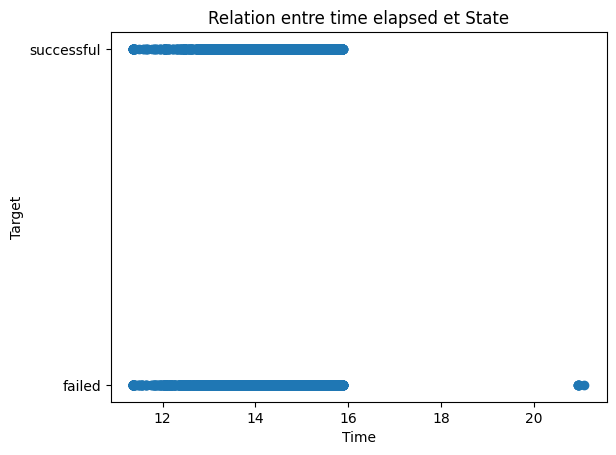

In [28]:
plt.scatter(df['time_elapsed_normalized'], df['state'])
plt.xlabel('Time')
plt.ylabel('Target')
plt.title('Relation entre time elapsed et State')
plt.show()

# Visuellement, passé une certaine durée, le taux de réussite est nul

In [29]:
# La fonction permet de calculer le ratio entre le nombre de succès et le nombre d'échecs, en fonction d'une condition donnée et d'une colonne spécifiée
class DataAnalyzer:
    def __init__(self, df, col):
        self.df = df
        self.col = col

    def calculate_count_and_ratio(self, condition):
        filtered_df_success = self.df[condition & (self.df['state'] == 'successful')]
        filtered_df_failed =self.df[condition & (self.df['state'] == 'failed')]
        count_successful = filtered_df_success[self.col].count()
        count_failed = filtered_df_failed[self.col].count()
        ratio = count_successful / count_failed * 100
        return ratio

    def analyze_data(self):
        col_to_compare = self.df[self.col]

        mean_value = col_to_compare.mean()
        ratio_higher_mean = self.calculate_count_and_ratio(col_to_compare > mean_value)
        ratio_lower_mean = self.calculate_count_and_ratio(col_to_compare < mean_value)

        q1 = col_to_compare.quantile(0.25)
        ratio_higher_q1 = self.calculate_count_and_ratio(col_to_compare > q1)
        ratio_lower_q1 = self.calculate_count_and_ratio(col_to_compare < q1)

        q3 = col_to_compare.quantile(0.75)
        ratio_higher_q3 = self.calculate_count_and_ratio(col_to_compare > q3)
        ratio_lower_q3 = self.calculate_count_and_ratio(col_to_compare < q3)

        return {
            'ratio_higher_mean': ratio_higher_mean,
            'ratio_lower_mean': ratio_lower_mean,

            'ratio_higher_q1': ratio_higher_q1,
            'ratio_lower_q1': ratio_lower_q1,

            'ratio_higher_q3': ratio_higher_q3,
            'ratio_lower_q3': ratio_lower_q3,
        }

In [30]:
data_analyzer = DataAnalyzer(df, col='time_elapsed')
analysis_results = data_analyzer.analyze_data()

In [31]:
df['time_elapsed'].describe()

count    3.236760e+05
mean     2.999903e+06
std      6.144961e+06
min      8.640000e+04
25%      2.592000e+06
50%      2.592000e+06
75%      3.279600e+06
max      1.446279e+09
Name: time_elapsed, dtype: float64

In [32]:
print("Ratio de campagnes réussies avec une durée supérieur à la moyenne:", analysis_results['ratio_higher_mean'])
print("Ratio de campagnes réussies avec une durée inférieur à la moyenne :", analysis_results['ratio_lower_mean'])
print("--------------------------------------------------")
print("Ratio de campagnes réussies avec une durée supérieur à q1:", analysis_results['ratio_higher_q1'])
print("Ratio de campagnes réussies avec une durée inférieur à q1:", analysis_results['ratio_lower_q1'])
print("--------------------------------------------------")
print("Ratio de campagnes réussies avec une durée supérieur à q3 :", analysis_results['ratio_higher_q3'])
print("Ratio de campagnes réussies avec une durée inférieur à q3:", analysis_results['ratio_lower_q3'])

Ratio de campagnes réussies avec une durée supérieur à la moyenne: 43.50517340777377
Ratio de campagnes réussies avec une durée inférieur à la moyenne : 61.07974321293217
--------------------------------------------------
Ratio de campagnes réussies avec une durée supérieur à q1: 52.88362039230115
Ratio de campagnes réussies avec une durée inférieur à q1: 84.7745807047238
--------------------------------------------------
Ratio de campagnes réussies avec une durée supérieur à q3 : 39.79337986317463
Ratio de campagnes réussies avec une durée inférieur à q3: 61.572511665368665


In [33]:
def convert_seconds_to_days(seconds):
    seconds_in_a_day = 24 * 60 * 60  # Nombre de secondes dans une journée
    days = seconds / seconds_in_a_day
    return days

In [34]:
print("Q1 en jours :", convert_seconds_to_days(df['time_elapsed'].quantile(0.25)))
print("Moyenne en jours :", convert_seconds_to_days(df['time_elapsed'].mean()))
print("Q3 en jours :", convert_seconds_to_days(df['time_elapsed'].quantile(0.75)))

# Les campagnes qui ont une durée inférieur à 30 jours, ont un taux de réussite de 84% !
# Au dela de 37 jours, le taux de réussite chute à moins de 40%

Q1 en jours : 30.0
Moyenne en jours : 34.721102751056385
Q3 en jours : 37.958333333333336


# Exploration du montant objectif à atteindre

Est-ce que le montant objectif d'une campagne a un impact sur sa réussite ? Par exemple, les campagnes avec des objectifs plus modestes ont-elles plus de chances de réussir que celles avec des objectifs élevés ?

In [35]:
df['currency'].unique()
# Les goal sont en monnaie correspondant à la currency. Toutes les monnaies n'ont pas la même valeur

array(['GBP', 'USD', 'CAD', 'NOK', 'AUD', 'EUR', 'MXN', 'SEK', 'NZD',
       'CHF', 'DKK', 'HKD', 'SGD'], dtype=object)

In [36]:
class ConvertGoalToUSD():
    def __init__(self):
      pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
      # Dictionnaire des taux de change
      exchange_rates = {
          'GBP': 1.39,  # Livre sterling
          'USD': 1.0,   # Dollar américain
          'CAD': 0.81,  # Dollar canadien
          'NOK': 0.12,  # Couronne norvégienne
          'AUD': 0.74,  # Dollar australien
          'EUR': 1.21,  # Euro
          'MXN': 0.05,  # Peso mexicain
          'SEK': 0.12,  # Couronne suédoise
          'NZD': 0.71,  # Dollar néo-zélandais
          'CHF': 1.09,  # Franc suisse
          'DKK': 0.16,  # Couronne danoise
          'HKD': 0.13,  # Dollar de Hong Kong
          'SGD': 0.74   # Dollar de Singapour
      }

      X['goal_usd'] = X.apply(lambda row: row['goal'] / exchange_rates[row['currency']], axis=1)
      return X

In [37]:
convert_goal_to_usd = ConvertGoalToUSD()
df = convert_goal_to_usd.transform(df)

In [38]:
df['goal_usd'].describe()
# Des objectifs très disparates. On va normaliser ces résultats pour pouvoir les traiter plus facilement
# Puisque le min et le max sont très différents, on va utiliser une transformation logarithmique pour étaler les valeurs sur une plage plus étroite

count    3.236760e+05
mean     6.860573e+04
std      2.522345e+06
min      1.000000e-02
25%      2.000000e+03
50%      5.000000e+03
75%      1.500000e+04
max      8.333333e+08
Name: goal_usd, dtype: float64

In [39]:
## Normaliser la colonne avec logarithmique
norm_log = NormalizedLogarithme(col='goal_usd')
df = norm_log.transform(df)

In [40]:
df['goal_usd_normalized'].describe()

count    323676.000000
mean          8.632799
std           1.752230
min           0.009950
25%           7.601402
50%           8.517393
75%           9.615872
max          20.540944
Name: goal_usd_normalized, dtype: float64

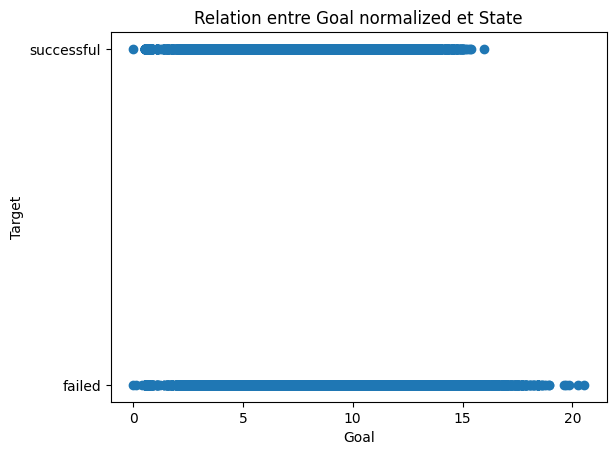

In [41]:
plt.scatter(df['goal_usd_normalized'], df['state'])
plt.xlabel('Goal')
plt.ylabel('Target')
plt.title('Relation entre Goal normalized et State')
plt.show()

In [42]:
data_analyzer = DataAnalyzer(df, col='goal_usd')
analysis_results = data_analyzer.analyze_data()

In [43]:
print("Ratio de campagnes réussies avec une durée supérieur à la moyenne:", analysis_results['ratio_higher_mean'])
print("Ratio de campagnes réussies avec une durée inférieur à la moyenne :", analysis_results['ratio_lower_mean'])
print("--------------------------------------------------")
print("Ratio de campagnes réussies avec une durée supérieur à q1:", analysis_results['ratio_higher_q1'])
print("Ratio de campagnes réussies avec une durée inférieur à q1:", analysis_results['ratio_lower_q1'])

# Les projets ayant un objectif supérieur à la moyenne des objectifs, ont un taux de réussites bien plus faible que ceux inférieur à la moyenne
# Une campagne qui a une objectifs inférieur à 2000 USD a une taux de réussite de plus de 90% !

Ratio de campagnes réussies avec une durée supérieur à la moyenne: 11.970795251602059
Ratio de campagnes réussies avec une durée inférieur à la moyenne : 59.89793490044687
--------------------------------------------------
Ratio de campagnes réussies avec une durée supérieur à q1: 45.63077017452382
Ratio de campagnes réussies avec une durée inférieur à q1: 92.08164925392104


In [44]:
print("Q1 :", df['goal_usd'].quantile(0.25))
print("Moyenne :", df['goal_usd'].mean())

Q1 : 2000.0
Moyenne : 68605.73129904397


# Exploration des engagements des backers

Est-ce que le nombre de contributeurs (backers) ou le montant des contributions (pledged) a un impact sur la réussite d'une campagne ? Les campagnes avec un grand nombre de backers ou des contributions élevées ont-elles tendance à réussir davantage ?

In [45]:
df['backers'].describe()

count    323676.000000
mean        101.518435
std         934.097786
min           0.000000
25%           2.000000
50%          12.000000
75%          55.000000
max      219382.000000
Name: backers, dtype: float64

In [46]:
df[df['backers'] == 219382]
# La ligne n'est pas une anomalie...
# Après vérification sur le site (https://www.kickstarter.com/projects/elanlee/exploding-kittens?ref=discovery&term=Exploding%20Kittens), la campagne a effectivement autant de contributeurs et a explosé son objectif !

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usdpledged,time_elapsed,time_elapsed_normalized,goal_usd,goal_usd_normalized
160566,1955357092,Exploding Kittens,Tabletop Games,Games,USD,2015-02-20 03:00:00,10000.0,2015-01-20 19:00:19,8782571.99,successful,219382,US,8782571.99,2620781.0,14.778983,10000.0,9.21044


In [47]:
len(df[df['backers'] > 100])
len(df[df['backers'] > 500])
len(df[df['backers'] > 1000])

4896

In [48]:
def calculate_project_succeed_by_backers(nb_backers):
  # Filtrer les projets avec au moins X contributeurs
  projects = df[df['backers'] >= nb_backers]

  # Calculer le nombre total de projets avec au moins X contributeurs
  total_projects = len(projects)

  # Filtrer les projets réussis parmi ceux avec au moins X contributeurs
  succeed_projects = projects[projects['state'] == 'successful']

  # Calculer le nombre de projets réussis avec au moins 12 contributeurs
  nb_succeed_projects = len(succeed_projects)

  # Calculer le pourcentage de projets réussis parmi ceux avec au moins 12 contributeurs
  res = (nb_succeed_projects / total_projects) * 100

  print(f"{res:.2f}% des projets qui ont au moins {nb_backers} contributeurs voient leur campagne réussie.")

In [49]:
calculate_project_succeed_by_backers(df['backers'].quantile(0.5))
calculate_project_succeed_by_backers(df['backers'].mean())
calculate_project_succeed_by_backers(df['backers'].quantile(0.75))
calculate_project_succeed_by_backers(1000)

# Plus il y a de contributeurs, plus la réussite de la campagne est assurée !
# Il faut compter à minima une dizaine de contributeurs pour avoir plus que 50% de chance de réussite

66.17% des projets qui ont au moins 12.0 contributeurs voient leur campagne réussie.
86.28% des projets qui ont au moins 101.51843510176843 contributeurs voient leur campagne réussie.
81.89% des projets qui ont au moins 55.0 contributeurs voient leur campagne réussie.
96.20% des projets qui ont au moins 1000 contributeurs voient leur campagne réussie.


# Preprocessing

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [51]:
df = load_csv(path)

In [52]:
class ConvertColumnToNumerical(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
       X = X.rename(columns=lambda x: x.replace(' ', ''))
       X = X.iloc[:, :-3]
       for column in self.columns:
          X[column] = pd.to_numeric(X[column], errors='coerce')
          X = X.dropna(subset=[column])
          X = X.reset_index(drop=True)
       return X

class BalanceDataset(BaseEstimator, TransformerMixin):
    def __init__(self):
      pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
      failed_rows = X[X['state'] == 'failed']
      successful_rows = X[X['state'] == 'successful']
      num_rows_to_remove = abs(len(failed_rows) - len(successful_rows))
      if len(failed_rows) > len(successful_rows):
          failed_rows = failed_rows.sample(n=num_rows_to_remove, random_state=42)
          X = pd.concat([failed_rows, successful_rows])
      else:
          successful_rows = successful_rows.sample(n=num_rows_to_remove, random_state=42)
          X = pd.concat([failed_rows, successful_rows])

      X = X.reset_index(drop=True)
      return X

In [53]:
preproc_pipeline = Pipeline([
    ('convert_column_to_numerical', ConvertColumnToNumerical(columns=['goal', 'pledged', 'backers'])),
    ('format_target', FormatTarget()), # Remplacer toutes les autres valeurs de State qui n'ont ni successful, ni failed
    ('balance_dataset', BalanceDataset()), # Supprimer de façon random x lignes dont le state = failed pour avoir un jeu équitable 50% failed et 50% successful
    ('calculate_elapsed_time', CalculateElapsedTime()), # Ajouter une colonne de la durée d'une campagne
    ('normalized_elapsed_time', NormalizedLogarithme(col='time_elapsed')), # Uniformiser la durée des campagnes
    ('convert_goal_to_usd', ConvertGoalToUSD()), # Uniformiser les Goal en USD
    ('normalized_goal', NormalizedLogarithme(col='goal_usd')), # Uniformiser les objectifs usd
])

preproc_pipeline.fit(df)
transformed_df = preproc_pipeline.transform(df)

In [54]:
transformed_df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usdpledged,time_elapsed,time_elapsed_normalized,goal_usd,goal_usd_normalized
0,1941792482,help me get to the NRL Grand Final (Suspended),Comedy,Film & Video,AUD,2015-10-07 08:14:32,500.0,2015-09-30 08:14:32,0.0,failed,0,AU,0,604800.0,13.312655,675.675676,6.517192
1,63427140,La Salsa Muy Salsa,Food,Food,USD,2015-03-23 22:47:24,8500.0,2015-02-21 23:47:24,767.0,failed,19,US,767,2588400.0,14.766551,8500.000000,9.047939
2,1322616199,Dream in the Making - My first CD project,Jazz,Music,USD,2015-06-23 04:18:56,7000.0,2015-05-24 04:18:56,730.0,failed,9,US,730,2592000.0,14.767941,7000.000000,8.853808
3,88177969,Craft Empire,Video Games,Games,GBP,2016-10-23 20:13:12,5000.0,2016-09-23 20:13:12,391.0,failed,14,GB,417.3143744,2592000.0,14.767941,3597.122302,8.188167
4,806705850,Righteous Anger: Why American Women Should Be ...,Publishing,Publishing,USD,2016-04-07 16:19:20,8000.0,2016-02-22 16:19:20,1161.0,failed,27,US,1161,3888000.0,15.173406,8000.000000,8.987322


In [55]:
# Splitter le jeu pour le train, et le test
col_selected = ['main_category', 'goal_usd_normalized', 'time_elapsed_normalized'] #, 'backers', 'usdpledged'
X_train, X_test, y_train, y_test = train_test_split(transformed_df[col_selected], transformed_df['state'], test_size=0.33, random_state=42)
X_train

,main_category,goal_usd_normalized,time_elapsed_normalized
36475,Music,8.853808,14.815639
83765,Games,9.936059,14.767941
150558,Music,6.216606,14.767941
20949,Technology,9.210440,14.767941
42261,Music,7.313887,14.700710
...,...,...,...
119879,Film & Video,10.308986,14.801732
103694,Music,8.779711,14.200727
131932,Music,8.006701,14.736592
146867,Games,9.903538,14.767941


# Création du modèle - entrainement - évaluation


In [56]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [57]:
def metrics(y_test, y_pred):
  # Calculer la matrice de confusion
  confusion = confusion_matrix(y_test, y_pred)
  print("Matrice de confusion:")
  print(confusion)

  # Calculer la précision
  precision = precision_score(y_test, y_pred)
  print("Précision:", precision)

  # Calculer le rappel
  recall = recall_score(y_test, y_pred)
  print("Rappel:", recall)

  # Calculer le score F1
  f1 = f1_score(y_test, y_pred)
  print("Score F1:", f1)

In [61]:
# Appliquer le LabelEncoder sur y_train et y_test pour mettre une valeur entre 0 et 1
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Encode les caractéristiques catégoriques
en = OneHotEncoder(handle_unknown='ignore')
X_train_encoded = en.fit_transform(X_train)

In [63]:
models = [
    ['LogisticRegression', LogisticRegression(max_iter=500, solver='newton-cg')],
    ['DecisionTreeClassifier', DecisionTreeClassifier()],
    ['RandomForestClassifier', RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=8, random_state=0, max_features=None)],
    ['KNeighborsClassifier', KNeighborsClassifier(n_neighbors=3, weights='distance')]
]

models_trained = []
for name, model in models:
    model.fit(X_train_encoded, y_train_encoded)

    X_test_encoded = en.transform(X_test)
    y_pred = model.predict(X_test_encoded)

    print('--------------------', name, '---------------------')
    metrics(y_test_encoded, y_pred)

    models_trained.append([name, model])

-------------------- LogisticRegression ---------------------
Matrice de confusion:
[[15979 14380]
 [ 9323 29002]]
Précision: 0.6685261168226453
Rappel: 0.7567384213959556
Score F1: 0.7099024563378902
-------------------- DecisionTreeClassifier ---------------------
Matrice de confusion:
[[16076 14283]
 [10950 27375]]
Précision: 0.6571366844303616
Rappel: 0.7142857142857143
Score F1: 0.6845204605978771
-------------------- RandomForestClassifier ---------------------
Matrice de confusion:
[[13705 16654]
 [ 9355 28970]]
Précision: 0.6349728213221112
Rappel: 0.7559034572733203
Score F1: 0.6901809431916998
-------------------- KNeighborsClassifier ---------------------
Matrice de confusion:
[[16199 14160]
 [14120 24205]]
Précision: 0.630913593118728
Rappel: 0.6315720808871493
Score F1: 0.6312426652757857


# Essai d'une nouvelle campagne

L'objectif est de prédire si ces campagnes sont susceptibles de réussir ou échouer.

In [80]:
# Lancement d'un nouveau projet
data = [{
    'ID': 1000015000,
    'name': 'New Project',
    'category': 'dance',
    'main_category': 'dance',
    'currency': 'USD',
    'deadline': '2023-11-30 23:59:59',
    'goal': 2000,
    'launched': '2023-11-01 09:00:00',
    'pledged': 0,
    'state': 'live',
    'backers': 0,
    'country': 'US',
    'usdpledged': 0
}, {
    'ID': 1000015022,
    'name': 'New Project',
    'category': 'Film & Video',
    'main_category': 'Film & Video',
    'currency': 'USD',
    'deadline': '2023-12-30 23:59:59',
    'goal': 100000,
    'launched': '2023-11-01 09:00:00',
    'pledged': 0,
    'state': 'live',
    'backers': 0,
    'country': 'US',
    'usdpledged': 0
}]

df_launched_campaign = pd.DataFrame(data)
df_launched_campaign

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usdpledged
0,1000015000,New Project,dance,dance,USD,2023-11-30 23:59:59,2000,2023-11-01 09:00:00,0,live,0,US,0
1,1000015022,New Project,Film & Video,Film & Video,USD,2023-12-30 23:59:59,100000,2023-11-01 09:00:00,0,live,0,US,0


In [81]:
preproc_pipeline = Pipeline([
    ('calculate_elapsed_time', CalculateElapsedTime()), # Ajouter une colonne de la durée d'une campagne
    ('normalized_elapsed_time', NormalizedLogarithme(col='time_elapsed')), # Uniformiser la durée des campagnes
    ('convert_goal_to_usd', ConvertGoalToUSD()), # Uniformiser les Goal en USD
    ('normalized_goal', NormalizedLogarithme(col='goal_usd')), # Uniformiser les objectifs usd
])

preproc_pipeline.fit(df_launched_campaign)
df_launched_campaign = preproc_pipeline.transform(df_launched_campaign)

X_encoded = en.transform(df_launched_campaign[col_selected])

In [82]:
for name, model in models:
    y_pred = model.predict(X_encoded)

    print(name, ': ', y_pred)

# D'après les modèles, la campagne optimisée pour réussir devrait réussir
# D'après les modèles, la campagne non optimisée pour réussir devrait échouer

LogisticRegression :  [1 0]
DecisionTreeClassifier :  [1 0]
RandomForestClassifier :  [1 1]
KNeighborsClassifier :  [1 0]


# Conclusion

## Réponses aux questions :

#1. Qualité des données
Le fichier CSV que j'ai utilisé était initialement délimité par des virgules, mais j'ai rencontré un problème lors de la lecture de la colonne 'name', car certains titres contenaient des virgules. Pour résoudre ce problème, j'ai décidé d'utiliser une boucle pour lire le fichier ligne par ligne et traiter les cas où la colonne 'name' avait des virgules. Généralement, ces virgules étaient suivies d'un espace, ce qui permettait de les distinguer du délimiteur standard. De plus, certaines valeurs de la colonne 'name' étaient encapsulées entre des guillemets.

Idéalement, j'aurais préféré que l'export CSV initial utilise un délimiteur différent, comme le point-virgule ';', afin d'éviter ce genre de problème lors de la lecture des données. Cela aurait permis une meilleure distinction entre les valeurs des différentes colonnes.

Malgré mes efforts pour traiter ces cas particuliers, il restait encore plusieurs dizaines de lignes qui posaient problème. J'ai donc pris la décision de les supprimer du dataset, considérant qu'il aurait été difficile de les intégrer de manière rapide. Toutefois, dans certains scénarios, il aurait peut-être été possible de trouver des solutions alternatives pour inclure ces données de manière appropriée.

#2. Exploration du jeu de données
Concernant les insights, j'avais émis plusieurs hypothèses en début de projet, voici celles qui m'ont semblé les plus pertinentes à étudier :
- Catégorie de projet : est-ce que certaines catégories de projets ont tendance à être plus réussies que d'autres ?
- Montant objectif (goal) : est-ce que le montant objectif d'une campagne a un impact sur sa réussite ? Par exemple, les campagnes avec des objectifs plus modestes ont-elles plus de chances de réussir que celles avec des objectifs élevés ?
- Durée de la campagne : est-ce que la durée d'une campagne influence son succès ? Les campagnes plus courtes ou plus longues ont-elles des taux de réussite différents ?
- Engagement des backers : est-ce que le nombre de contributeurs (backers) ou le montant des contributions (pledged) a un impact sur la réussite d'une campagne ? Les campagnes avec un grand nombre de backers ou des contributions élevées ont-elles tendance à réussir davantage ?

Pour que les insights et leur interprétation soient statistiquement significatifs, il serait intéressant de réaliser des analyses statistiques appropriées. Cela peut inclure des tests d'hypothèses, des analyses de corrélation, des régressions, etc. Il est également essentiel de prendre en compte la taille de l'échantillon, les biais potentiels et de tenir compte du contexte global de l'ensemble des données.

Les insights trouvés peuvent certainement être transformés en caractéristiques qui faciliteront l'apprentissage du modèle ML. Par exemple, les caractéristiques basées sur la catégorie de projet, le montant objectif, la durée de la campagne et l'engagement des backers peuvent être utilisées comme variables d'entrée pour le modèle.

#3. Analyse des résultats

Les modèles créés permettent de prédire si une campagne va être réussie ou si elle va échouer. Les modèles ont été entrainés avec seulement 3 features : la catégorie principale, l'objectif en usd et la durée d'une campagne. Features que l'on peut avoir dès le lancement d'une campagne. \
Résultats des modèles :

|                           | Matrice de confusion | Précision | Rappel  | Score F1 |
|---------------------------|---------------------|-----------|---------|----------|
| **LogisticRegression**        | [[15979 14380]      | 0.6685    | 0.7567  | 0.7099   |
|                           |  [9323 29002]]      |           |         |          |
| DecisionTreeClassifier    | [[16076 14283]      | 0.6571    | 0.7143  | 0.6845   |
|                           |  [10950 27375]]     |           |         |          |
| RandomForestClassifier    | [[13705 16654]      | 0.6350    | 0.7559  | 0.6902   |
|                           |  [9355 28970]]      |           |         |          |
| KNeighborsClassifier      | [[16199 14160]      | 0.6309    | 0.6316  | 0.6312   |
|                           |  [14120 24205]]     |           |         |          |


- Matrice de confusion : La matrice de confusion présente le nombre de prédictions correctes et incorrectes effectuées par chaque modèle. Elle est organisée en quatre quadrants : les vrais positifs (dans le coin supérieur gauche), les vrais négatifs (dans le coin inférieur droit), les faux positifs (dans le coin supérieur droit) et les faux négatifs (dans le coin inférieur gauche). Dans notre cas, tous les modèles sont moyens et ont tendance à être plus optimiste que la réalité, c'est-à-dire qu'ils penses que plus de 14 000 campagnes vont réussir  alors qu'elles ont échouées.
  - TP : le modèle reconnait une campagne réussie qui l'est réellement
  - TN : le modèle reconnait une campagne échoué qui l'est réellement
  - FP : le modèle reconnait une campagne échoué comme réussie
  - FN : le modèle reconnait une campagne réussie comme échouée

- Précision : La précision mesure la proportion de prédictions positives correctes parmi toutes les prédictions positives effectuées par le modèle. Dans notre cas, la précision est comprise entre 0.63 et 0.67, ce qui indique que les modèles arrivent à prédire, dans plus de la majorité des cas, les campagnes réussies qui ont effectivement réussies. Plus la précision est proche de 1, moins les modèles prédisent des campagnes qui ont échouées comme ayant réussies (moins le modèle se trompe sur les succès).
- Rappel : Le rappel mesure la proportion de vrais positifs identifiés parmi tous les cas réellement positifs. Un rappel de 1.0 signifie que tous les vrais positifs ont été correctement identifiés. Dans notre cas, le rappel est compris en 0.63 et 0.75, ce qui signifie que les modèles ont tendance à repérer les campagnes ayant réussies.
- Score F1 : Le score F1 est une mesure de la précision et du rappel combinés, calculée comme la moyenne pondérée de ces deux métriques. Il permet d'évaluer l'équilibre entre la précision et le rappel. Dans notre cas, le meilleur score F1 est de 0.71.


Voici mes recommandations pour aider un promoteur dans la réussite de ses campagnes :
- Choisir des catégories à fort taux de réussite : Les catégories comme le théâtre, la danse, les comics et la musique ont des taux de réussite supérieurs ou proches de 50%.
- Fixer un objectif de financement réaliste et atteignable : Les projets avec un objectif de financement inférieur à 2000$ ont une probabilité de réussite plus élevée, avec une augmentation de 90% de chances d'aboutir.
- Opter pour une durée de campagne courte : Les campagnes d'une durée inférieure à 30 jours ont un taux de réussite élevé, avec 92% des campagnes de cette durée réussissant.
- Etre attractif pour obtenir plus de contributeurs : Les campagnes ayant plus d'une dizaine de contributeurs ont un taux de réussite de plus de 60%. Plus il y a de contributeurs, plus les chances de réussites sont élevées. Proposer des récompenses pour les contributeurs pourraient jouer un rôle crucial dans le succès de la campagne. Il faut s'assurer d'offrir des récompenses attrayantes et pertinentes en fonction du montant des contributions. Cela peut inclure des avantages exclusifs, des exemplaires du produit fini, des expériences uniques ou tout autre élément qui valorise la participation des contributeurs.


Avec le meilleur modèle, sur 100 campagnes optimisées pour réussir, 67 réussiront vraiment. Autrement sur 100 campagnes, seulement 35% devraient réussir (basé sur le jeu de données). Avec les optimisations, nous sommes capables d'abaisser le taux de projets qui n'aboutissent pas à 33% contre 64% avant. On pourrait donc réduire de 31% le nombre de projets qui n'aboutissent pas en succès.

Cependant, il est important de rappeler que ces chiffres sont des estimations et que les résultats réels peuvent varier en fonction de nombreux autres facteurs non pris en compte par le modèle.


#4. Risques liés à un déploiement
Si la solution venait à être déployée, je prendrais en considération le risque potentiel lié à la gestion des nouvelles catégories qui peuvent apparaître, puisque la solution actuelle se base sur le OneHotEncoder. Si de nouvelles catégories sont présentes dans les données de déploiement qui n'ont pas été rencontrées lors de l'apprentissage du modèle, cela peut entraîner des erreurs lors de la transformation des données en one-hot encoding, ou avoir des résultats de moins bonnes qualités.

Pour mitigérer ce risque, voici quelques approches auxquelles je pense :
- Collecter régulièrement les catégories : Mettre en place un processus de surveillance des nouvelles catégories. Il pourrait être judicieux de collecter régulièrement les catégories présentes dans les nouvelles données et de les comparer avec les catégories déjà connues. Cela permettra de détecter les nouvelles catégories et de mettre à jour le codage en conséquence.
- Gérer les catégories inconnues : Prévoir une stratégie pour gérer les catégories inconnues lors de l'encodage en one-hot. Par exemple, les catégories inconnues peuvent être traitées comme une catégorie distincte ou assignées à une catégorie spécifique réservée aux catégories inconnues.
- Mettre à jour le modèle : Si de nouvelles catégories apparaissent fréquemment dans les données, il sera nécessaire de mettre à jour périodiquement le modèle en incluant les nouvelles catégories dans l'encodage. Cela peut impliquer un nouvel entrainement du modèle.